In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import dataframe_image as dfi

In [2]:
## Import data from https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
## Shapefile enables plotting of census tracts, neighborhoods, borough, etc. by coordinates
census_tract_shapes = gpd.read_file('data/geo_export_e2cd3cf8-21c0-468e-9274-ad3af1e7d5c9.shp')

In [3]:
nyc_tree = pd.read_csv('data/2015_Street_Tree_Census_-_Tree_Data.csv')
nyc_tree = nyc_tree.loc[nyc_tree.status == 'Alive'] 

In [4]:
dfi.export(nyc_tree[['health', 'tree_dbh', 'curb_loc', 'spc_latin', 'root_stone',
          'trnk_light', 'steward', 'brch_shoe', 'borough', 'nta_name',
          'latitude', 'longitude', 'census tract']].sample(3), 'data/images/sample_table.png')

In [5]:
## Allows for counting of rows when using groupby function
nyc_tree['counter'] = 1

In [6]:
nyc_tree.health.value_counts()

Good    528850
Fair     96504
Poor     26818
Name: health, dtype: int64

In [7]:
nyc_tree['good_health_tree'] = nyc_tree.health.apply(lambda x: 1 if x=='Good' else 0)
nyc_tree['fair_health_tree'] = nyc_tree.health.apply(lambda x: 1 if x=='Fair' else 0)
nyc_tree['poor_health_tree'] = nyc_tree.health.apply(lambda x: 1 if x=='Poor' else 0)

In [8]:
## Reduce number of shapes from 2165 census tracts to 195 neighborhoods
neighborhood_shapes = census_tract_shapes.dissolve(by='ntaname')

In [9]:
neighborhood_trees = nyc_tree.groupby('nta_name').sum()

In [10]:
neighborhood_trees['percent_substandard'] = ((neighborhood_trees.fair_health_tree + neighborhood_trees.poor_health_tree)
                                            / neighborhood_trees.counter) * 100

In [11]:
## Join shape dataset and tree dataset on neighborhood name indexes
trees_by_neighborhood = neighborhood_trees.join(neighborhood_shapes)

In [12]:
trees_by_neighborhood = gpd.GeoDataFrame(trees_by_neighborhood)

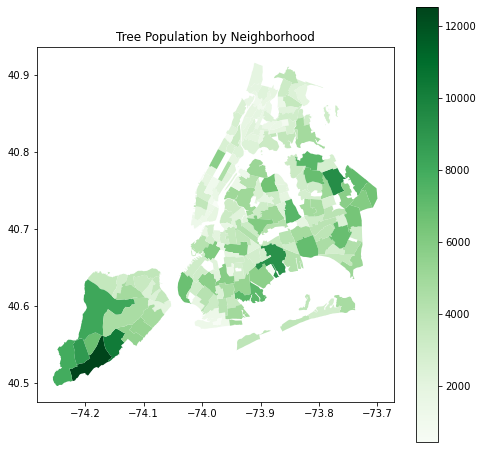

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = (trees_by_neighborhood.plot(ax=ax, column='counter', legend=True, cmap='Greens')
      .set_title('Tree Population by Neighborhood'))
plt.savefig('data/images/tree_pop.png')

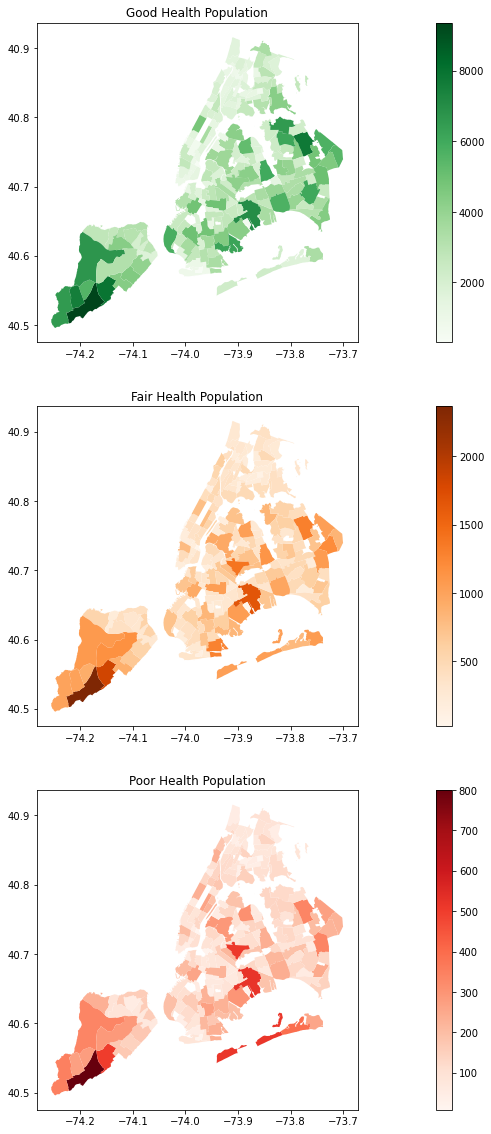

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28, 20))
ax1 = (trees_by_neighborhood.plot(ax=ax1, column='good_health_tree', legend=True, cmap='Greens')
                            .set_title('Good Health Population'))
ax2 = (trees_by_neighborhood.plot(ax=ax2, column='fair_health_tree', legend=True, cmap='Oranges')
                            .set_title('Fair Health Population'))
ax3 = (trees_by_neighborhood.plot(ax=ax3, column='poor_health_tree', legend=True, cmap='Reds')
                            .set_title('Poor Health Population'))
plt.savefig('data/images/pop_by_health.png')

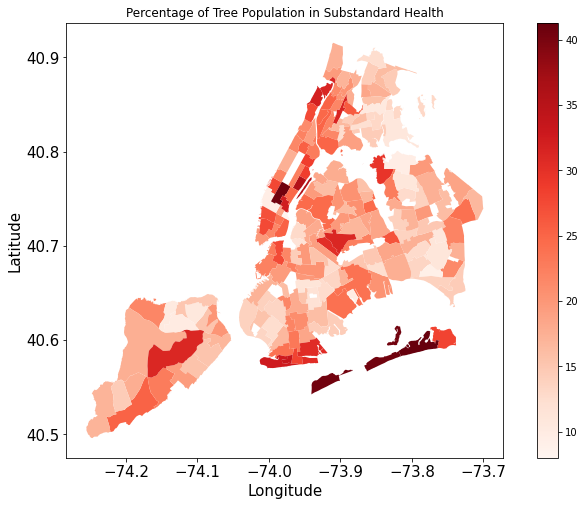

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.tick_params(axis='both', labelsize=15)
ax = (trees_by_neighborhood.plot(ax=ax, column='percent_substandard', legend=True, cmap='Reds')
                            .set_title('Percentage of Tree Population in Substandard Health'))
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.savefig('data/images/substandard_pop.png')

In [15]:
dfi.export(trees_by_neighborhood.sort_values(by='percent_substandard',
                                             ascending=False)[['percent_substandard', 'boro_name']][:10],
                                             'data/images/top_substandards.png')

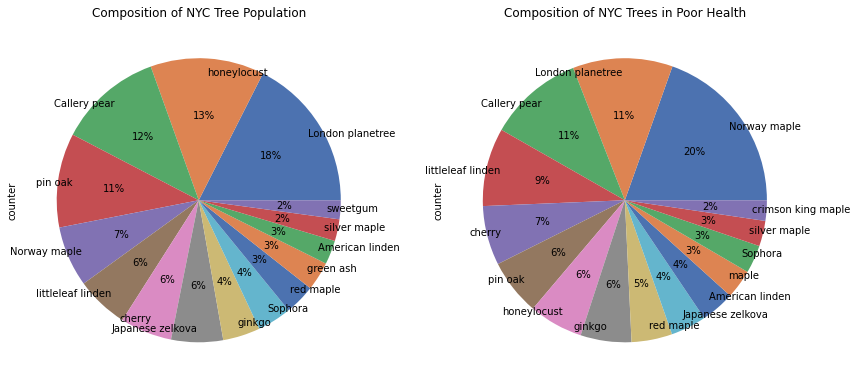

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
ax1 = (nyc_tree.groupby('spc_common')['counter'].count().nlargest(15).plot(ax=ax1, kind='pie', colors=sns.color_palette('deep'),
       labels=nyc_tree.groupby('spc_common')['counter'].count().nlargest(15).index,
       autopct='%1.0f%%', labeldistance=.9)
       .set_title('Composition of NYC Tree Population'))
ax2 = (nyc_tree.loc[nyc_tree.health == 'Poor'].groupby('spc_common')['counter'].count().nlargest(15).plot(ax=ax2, kind='pie',
       colors=sns.color_palette('deep'),
       labels=nyc_tree.loc[nyc_tree.health == 'Poor'].groupby('spc_common')['counter'].count().nlargest(15).index,
       autopct='%1.0f%%',labeldistance=.9).set_title('Composition of NYC Trees in Poor Health'));